
=== Data Cleansing ===
Jumlah baris awal: 1470
Setelah hapus duplikat: 1470
Jumlah missing value per kolom:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear

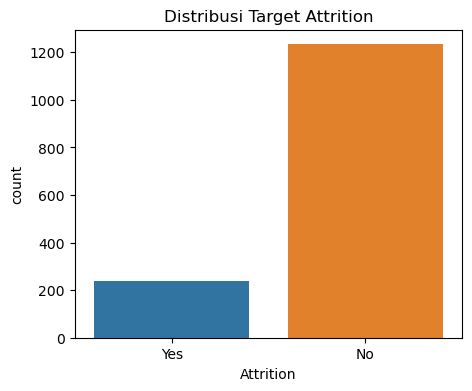

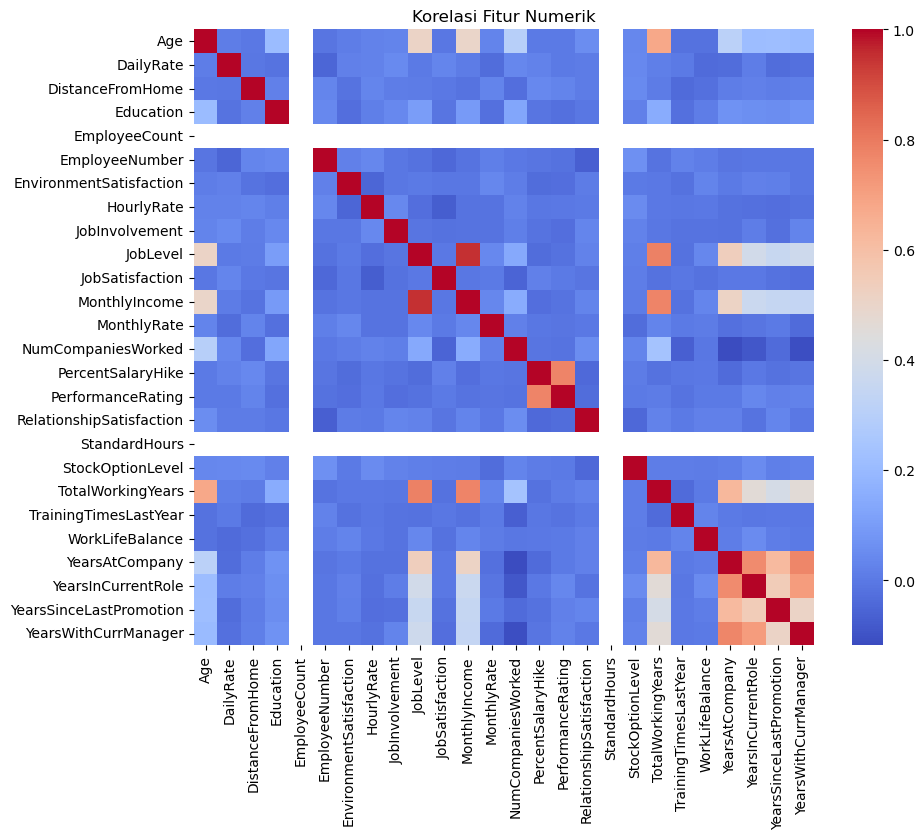

Logistic Regression - AUC: 0.810
Random Forest - AUC: 0.812
Gradient Boosting - AUC: 0.797

Model Terbaik: Random Forest (AUC = 0.812)


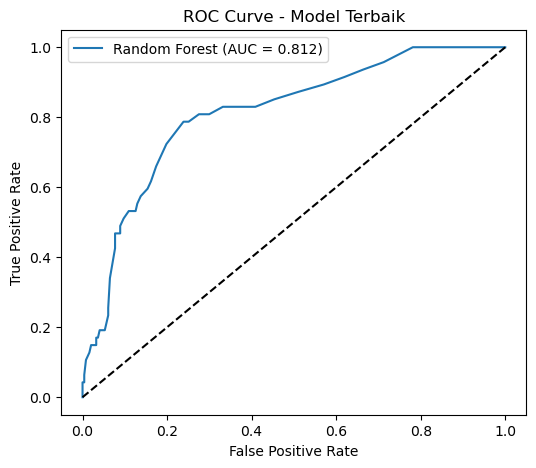


=== Insight & Strategi Retensi ===


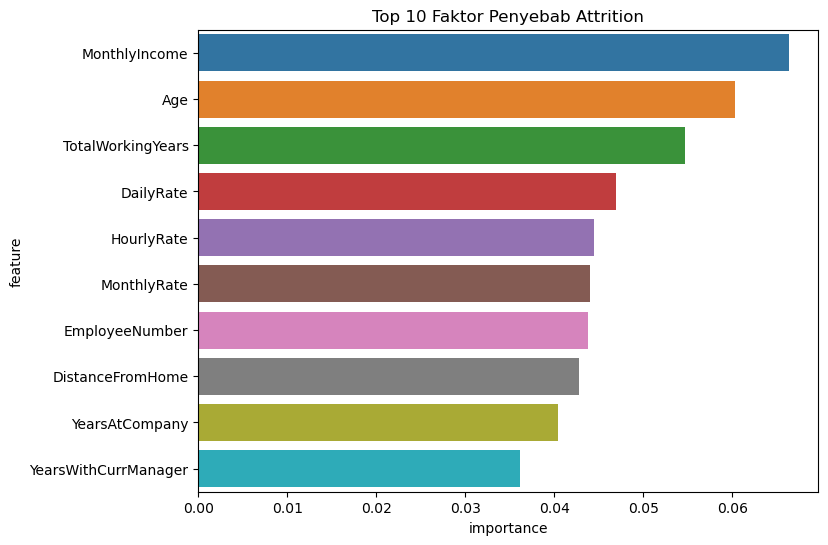

- Fokus pada faktor dengan importance tertinggi, misalnya kompensasi, jam kerja, dan lingkungan kerja.
- Perhatikan karyawan dengan masa kerja singkat atau performa tinggi yang berisiko keluar.
- Lakukan program career development dan engagement untuk departemen rawan turnover.
- Evaluasi kebijakan kerja fleksibel atau work-life balance untuk meningkatkan retensi.


In [11]:
# ================================================
# HR Attrition Analysis, Prediction & Retention Strategy
# Dataset: WA_Fn-UseC_-HR-Employee-Attrition.csv
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# -----------------------
# 1. Load Dataset
# -----------------------
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# -----------------------
# 2. Data Cleansing
# -----------------------
print("\n=== Data Cleansing ===")
print(f"Jumlah baris awal: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Setelah hapus duplikat: {len(df)}")
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

# -----------------------
# 3. EDA
# -----------------------

# Distribusi target
plt.figure(figsize=(5,4))
sns.countplot(x='Attrition', data=df)
plt.title("Distribusi Target Attrition")
plt.show()

# Korelasi fitur numerik
num_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Korelasi Fitur Numerik")
plt.show()

# -----------------------
# 4. Encoding target
# -----------------------
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# -----------------------
# 5. Pisahkan fitur & target
# -----------------------
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Fitur numerik & kategorikal
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

# -----------------------
# 6. Preprocessor pipeline
# -----------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# -----------------------
# 7. Train-Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------
# 8. Model Training & Evaluation
# -----------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob)
    results[name] = {"auc": auc, "model": clf}
    print(f"{name} - AUC: {auc:.3f}")

# -----------------------
# 9. Pilih Model Terbaik
# -----------------------
auc_scores = {name: info["auc"] for name, info in results.items()}
best_name = max(auc_scores, key=auc_scores.get)
best_clf = results[best_name]["model"]

print(f"\nModel Terbaik: {best_name} (AUC = {auc_scores[best_name]:.3f})")

# -----------------------
# 10. ROC Curve Model Terbaik
# -----------------------
y_best_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_best_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_name} (AUC = {auc_scores[best_name]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Terbaik')
plt.legend()
plt.show()

# -----------------------
# 11. Insight & Strategi Retensi
# -----------------------
print("\n=== Insight & Strategi Retensi ===")

# Ambil nama fitur setelah preprocessing
ohe_features = best_clf.named_steps["preprocessor"].transformers_[1][1]\
                .named_steps["encoder"].get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, ohe_features])

# Feature importance
if hasattr(best_clf.named_steps["classifier"], "feature_importances_"):
    importances = best_clf.named_steps["classifier"].feature_importances_
    feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
elif hasattr(best_clf.named_steps["classifier"], "coef_"):
    importances = np.abs(best_clf.named_steps["classifier"].coef_[0])
    feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
else:
    feat_imp = pd.DataFrame({"feature": all_features, "importance": np.nan})

feat_imp = feat_imp.sort_values(by="importance", ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Top 10 Faktor Penyebab Attrition")
plt.show()

print("- Fokus pada faktor dengan importance tertinggi, misalnya kompensasi, jam kerja, dan lingkungan kerja.")
print("- Perhatikan karyawan dengan masa kerja singkat atau performa tinggi yang berisiko keluar.")
print("- Lakukan program career development dan engagement untuk departemen rawan turnover.")
print("- Evaluasi kebijakan kerja fleksibel atau work-life balance untuk meningkatkan retensi.")
